In [2]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
import seaborn as sns

from sklearn.decomposition import PCA
from umap import UMAP

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model
import time

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [3]:
dir = '../data/real/hori/Pancreas/'

counts_rnas = []
counts_atacs = []
for batch in range(8):
    counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
    # preprocess the count matrix
    counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    counts_rnas.append(counts_rna)


counts = {"rna":counts_rnas}

In [4]:
# train model
# last one is the one fit into the original model
alpha = [1000, 1, 100, 100, 0.00]
#hyper parameters
batchsize = 0.3
lr = 1e-2
run = 0

Ns = [10] * 8
K = 10
N_feat = Ns[0] + 1

model1 = model.cfrm_new2(counts = counts, interacts = None, Ns = Ns, K = K, N_feat = N_feat, 
                         batch_size = batchsize, interval=1000, lr=1e-3, alpha =alpha, seed = run).to(device)
losses = model1.train_func(T = 4000)

Input sanity check...
Finished.
Epoch 1000, Validating Loss: 185.9603
	 loss 1: 185.96033
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 2000, Validating Loss: 177.6637
	 loss 1: 177.66365
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 3000, Validating Loss: 172.5249
	 loss 1: 172.52489
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000
Epoch 4000, Validating Loss: 171.2526
	 loss 1: 171.25259
	 loss 2: 0.00000
	 loss 3: 0.00000
	 loss 4: 0.00000
	 loss 5: 0.00000


In [5]:
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
zs = []
labels = []
pre_labels = []
for batch in range(8):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(8):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 7:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

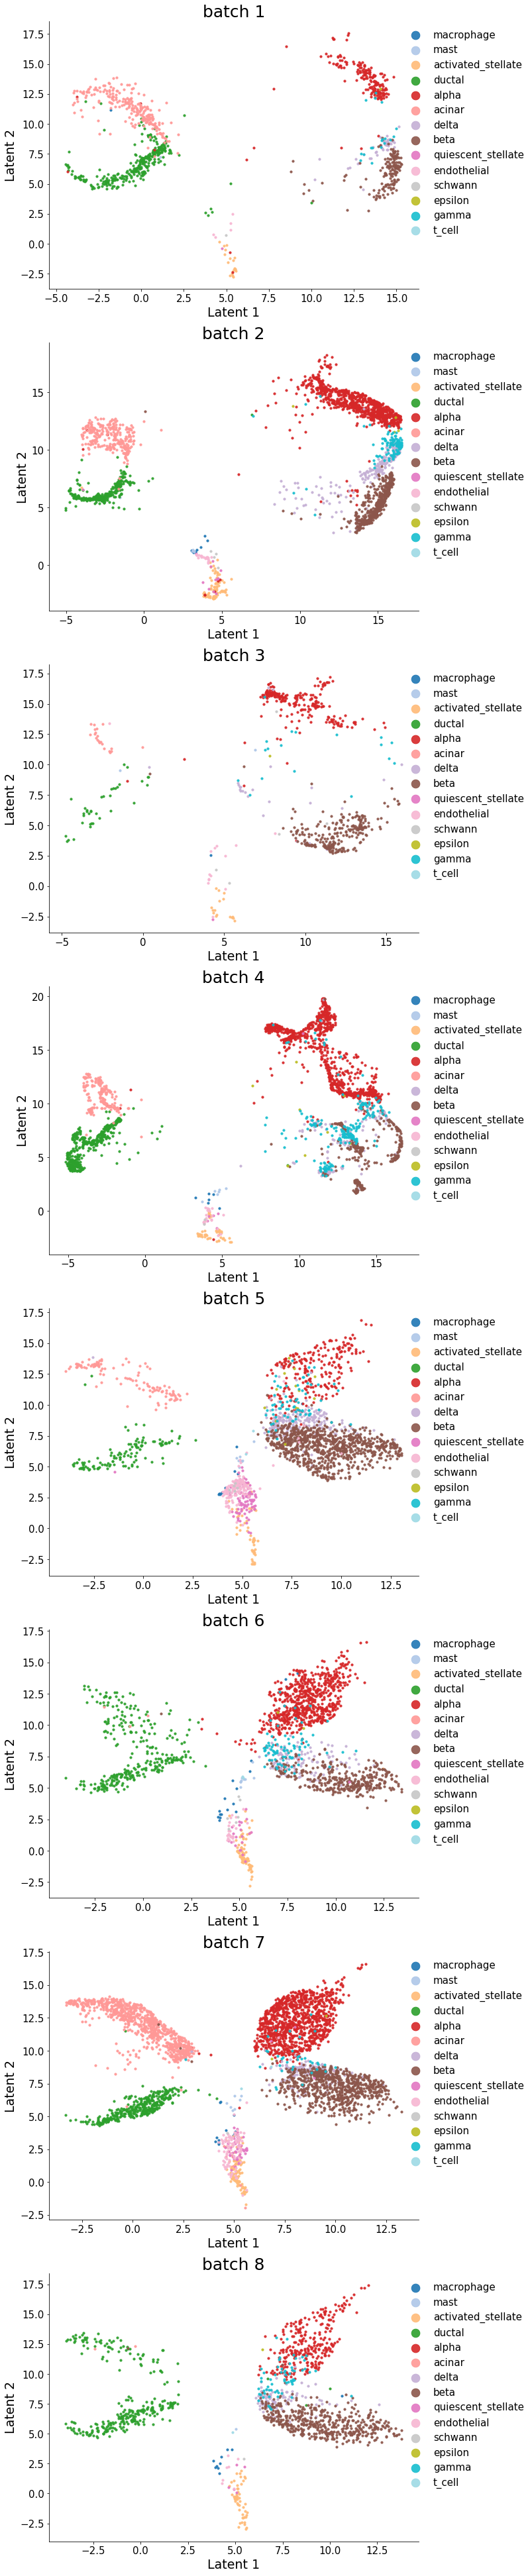

In [6]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,70), axis_label = "Latent")


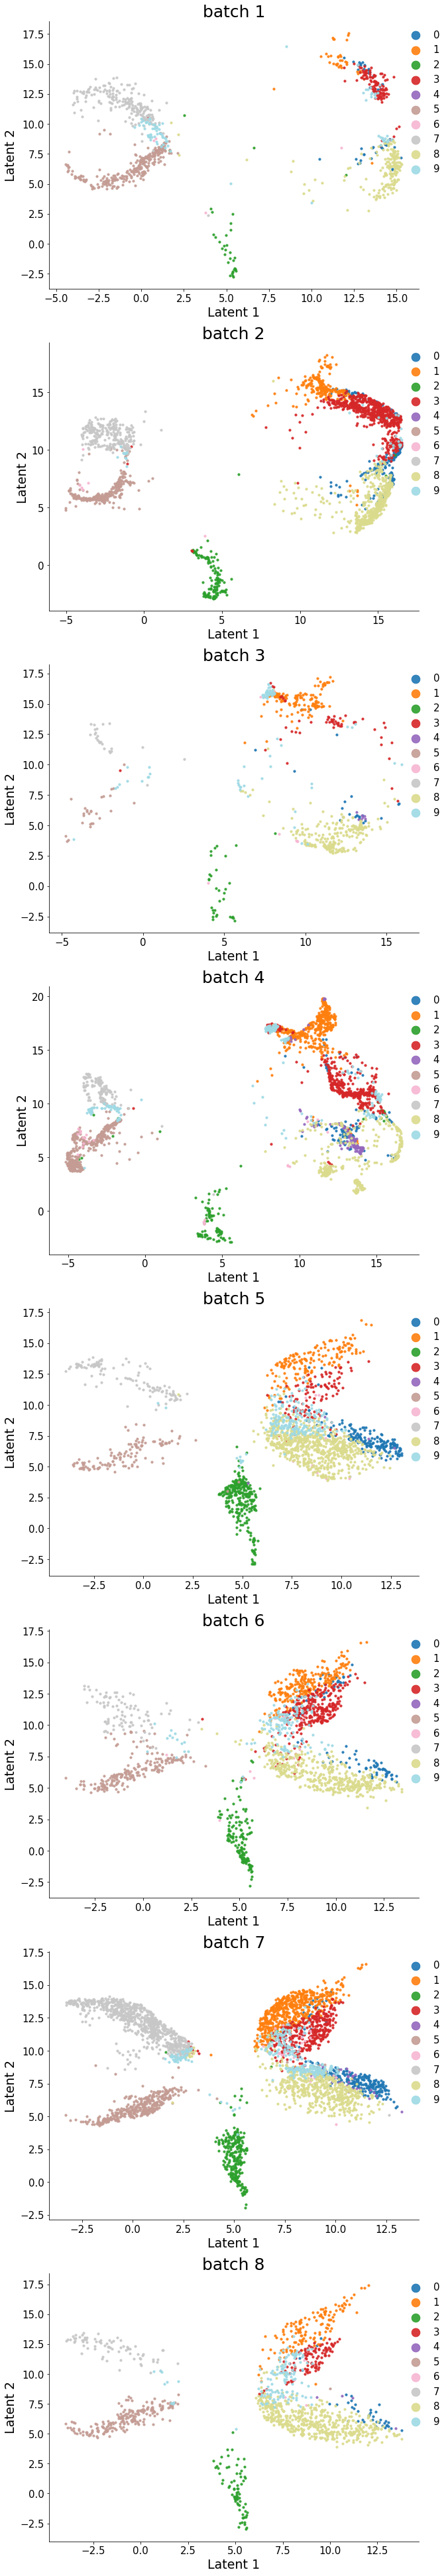

In [7]:
utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "separate", save = None, 
                      figsize = (10,70), axis_label = "Latent")


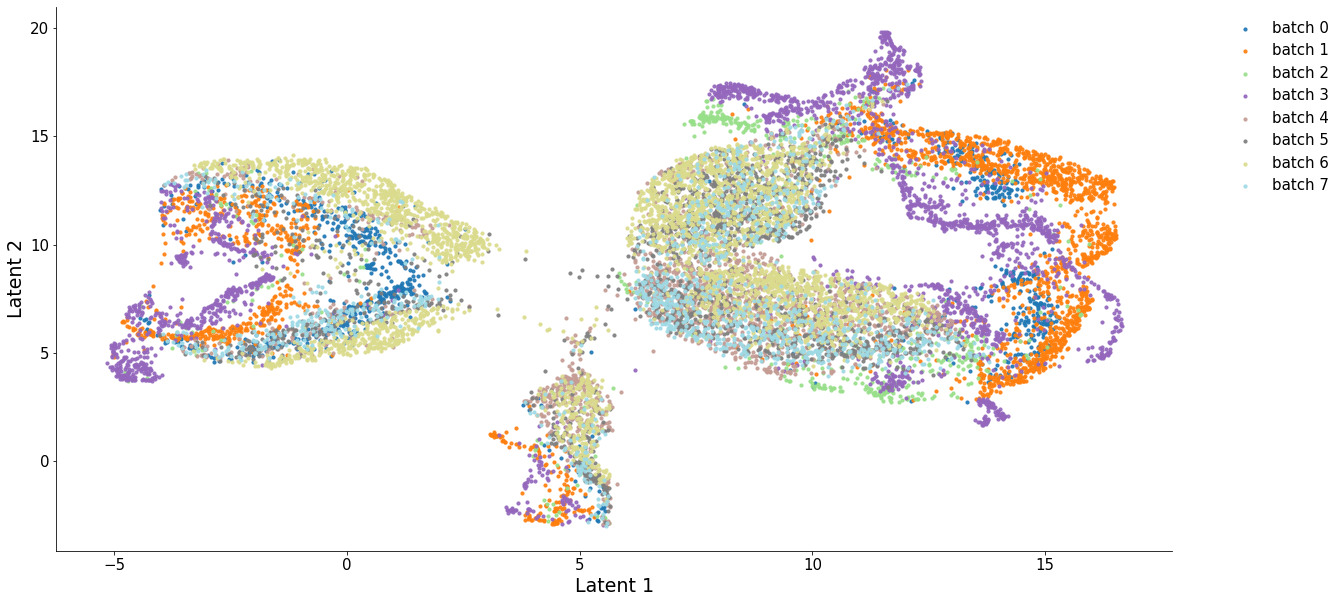

In [8]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


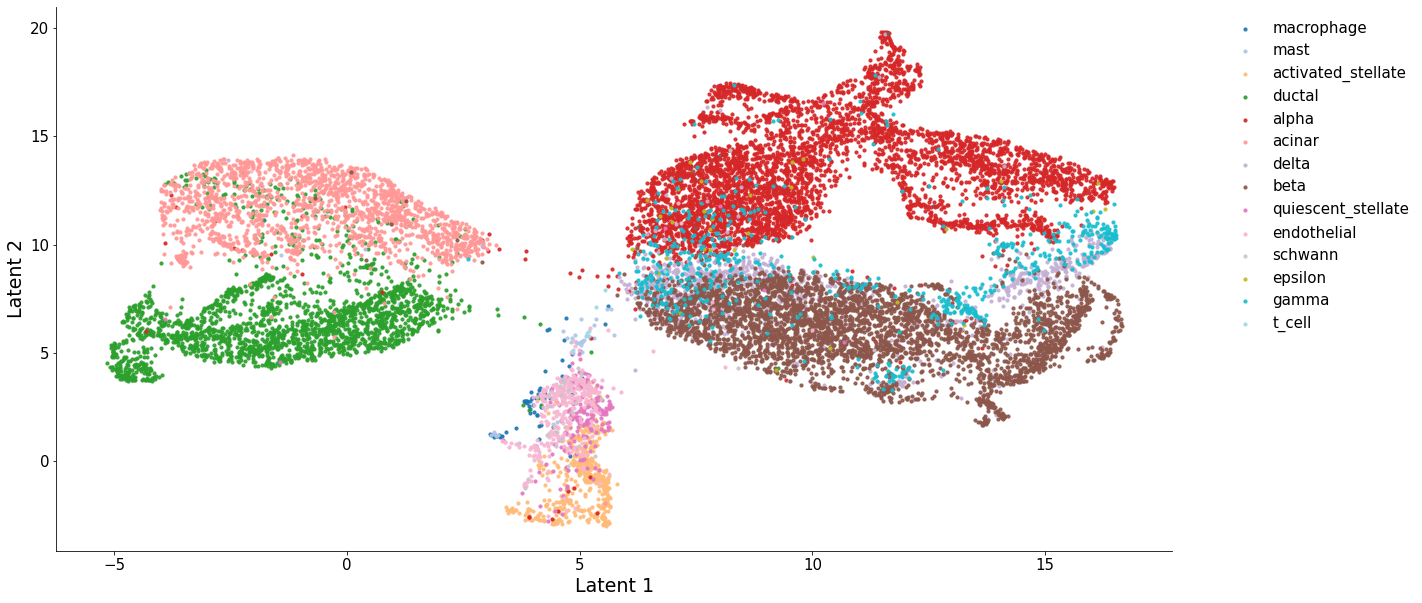

In [9]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


## Post-processing

In [10]:
zs = []
labels = []
pre_labels = []
for batch in range(8):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

zs2 = quantile.quantile_norm(zs)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(8):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 7:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

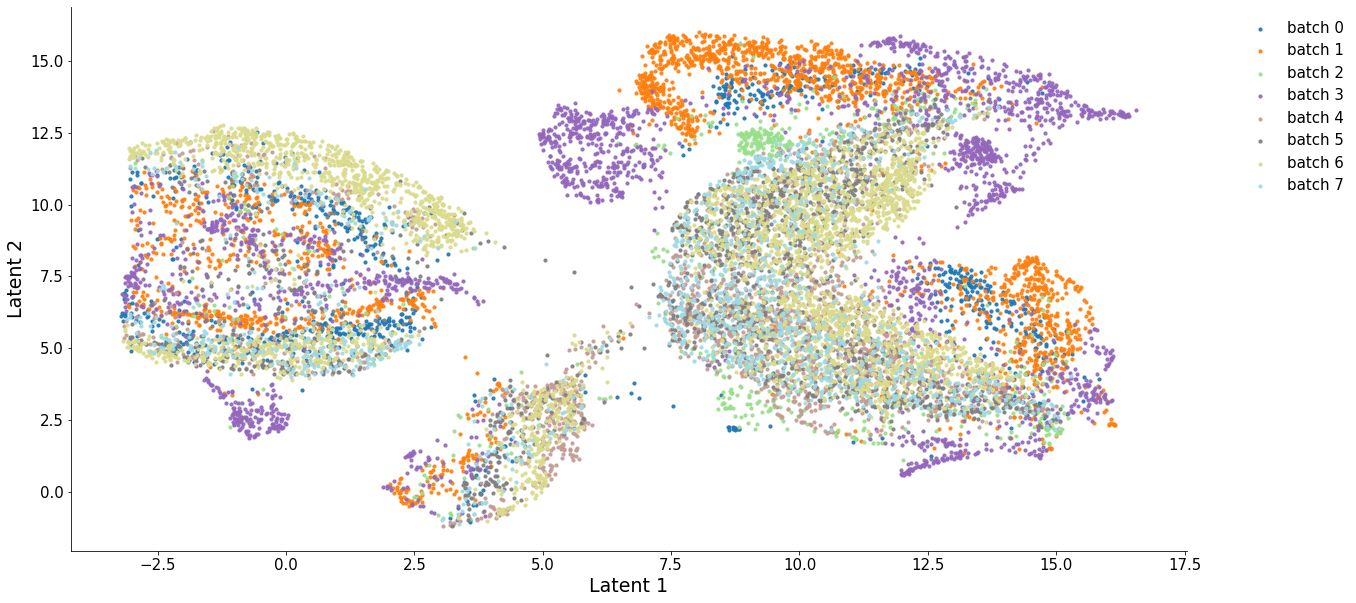

In [11]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


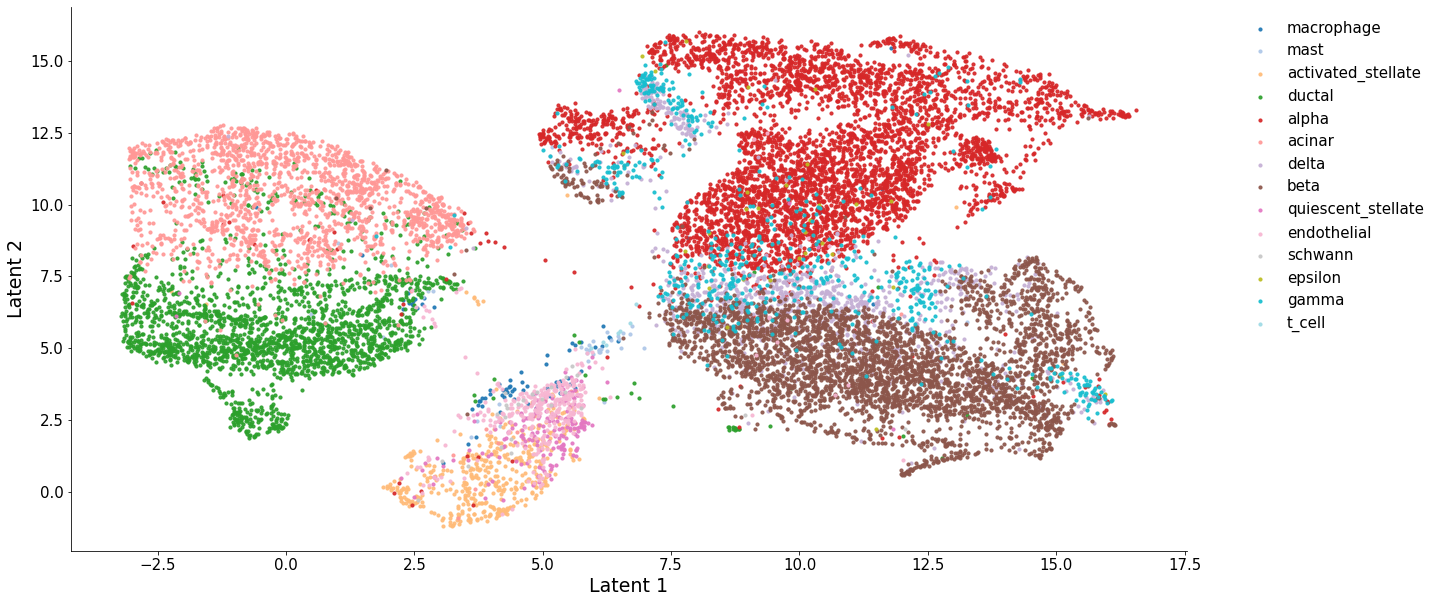

In [12]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


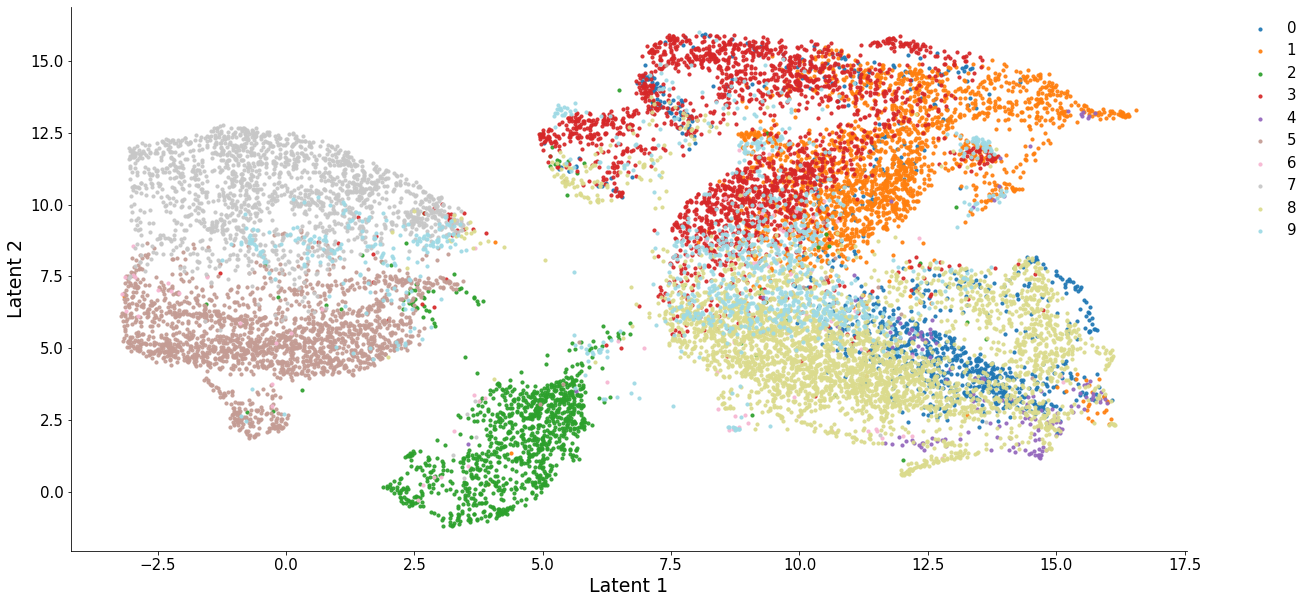

In [13]:
utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


In [39]:
zs = []
labels = []
pre_labels = []
for batch in range(8):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
zs2 = utils.match_embeds(zs, k = 10, reference = None, bandwidth = 40)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(8):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 7:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

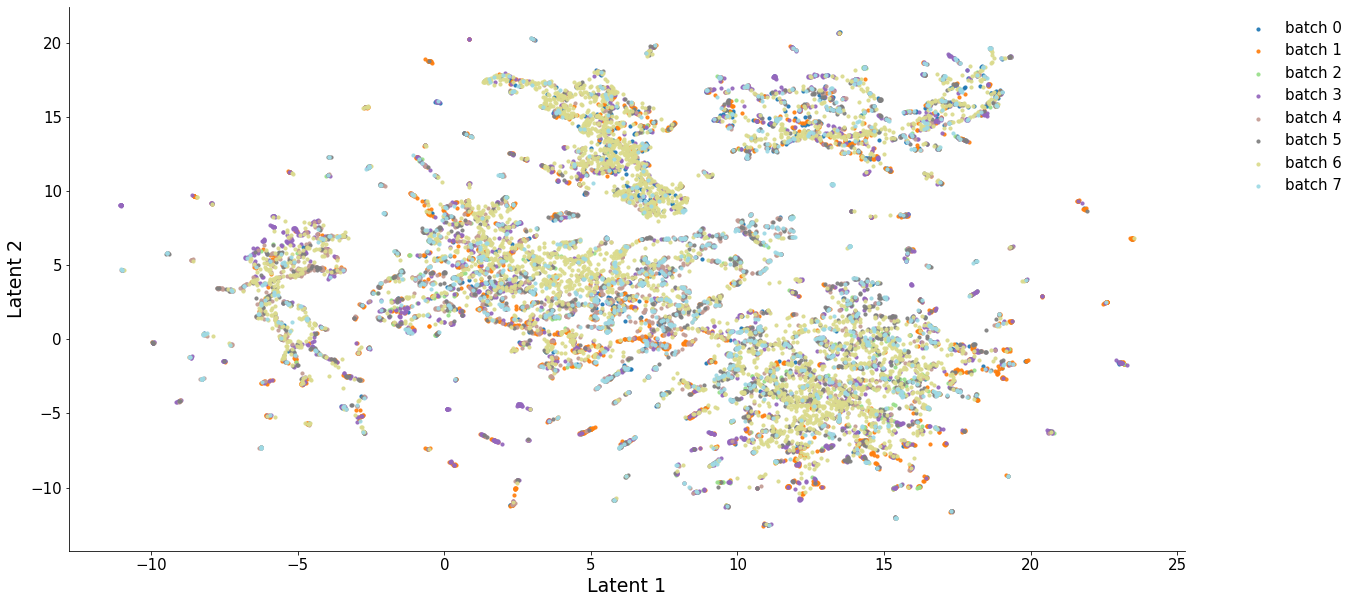

In [40]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


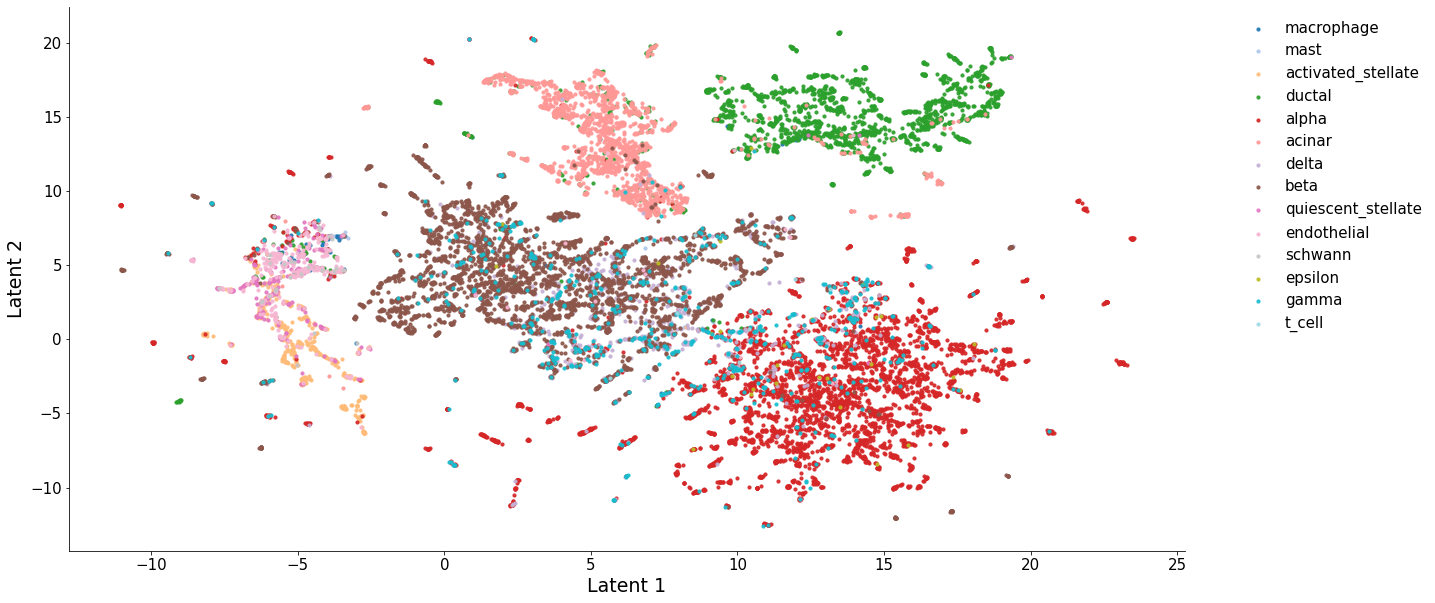

In [41]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


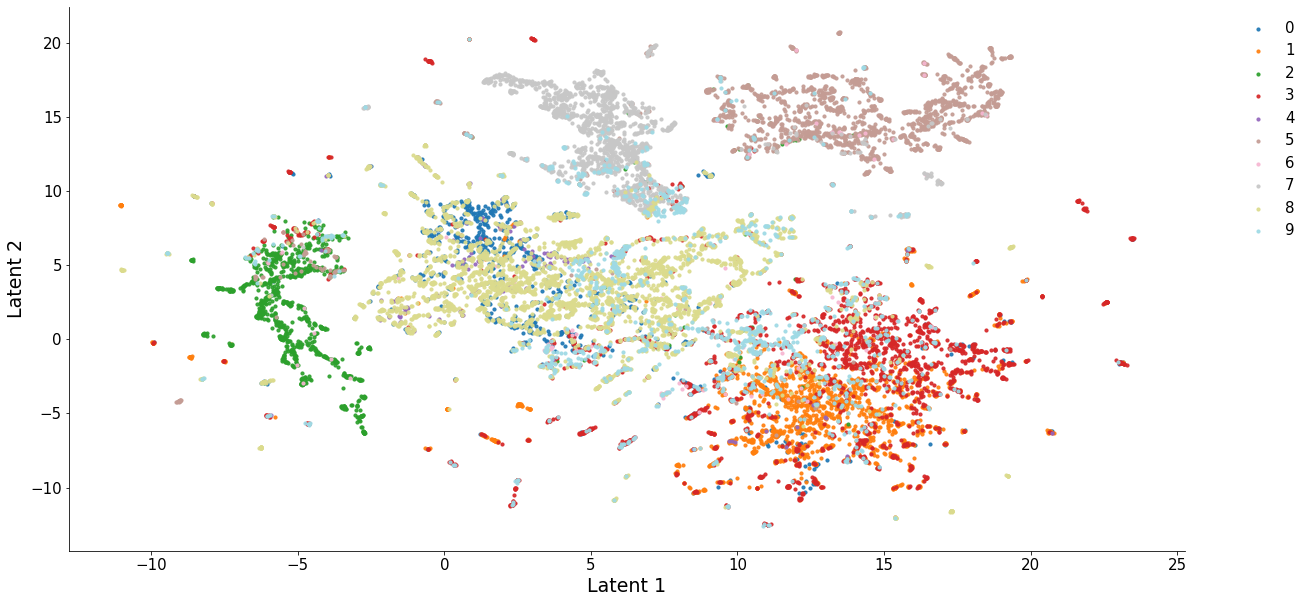

In [42]:
utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


In [18]:
import importlib 
importlib.reload(utils)

<module 'utils' from '../src/utils.py'>

In [27]:
zs = []
labels = []
pre_labels = []
for batch in range(8):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch) + '.csv'), index_col=0)["celltype"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
zs2 = utils.match_embeds_clust(zs, k = 10, reference = None, bandwidth = 1)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(8):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 7:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

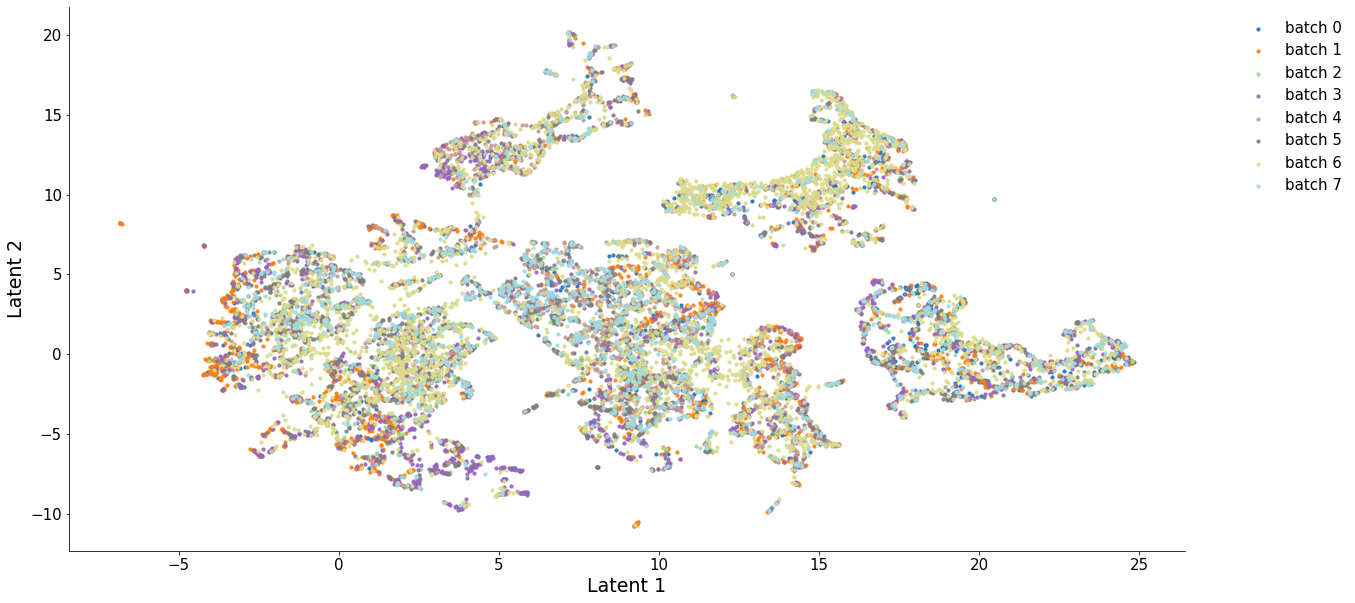

In [28]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


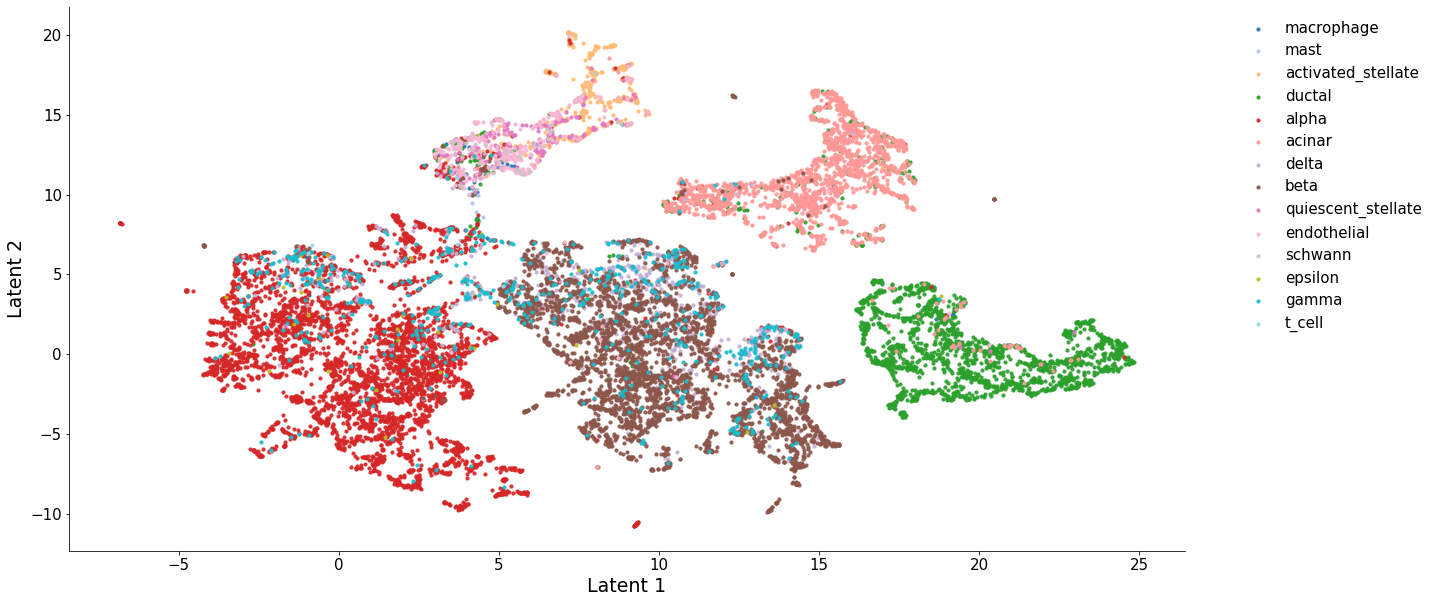

In [29]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


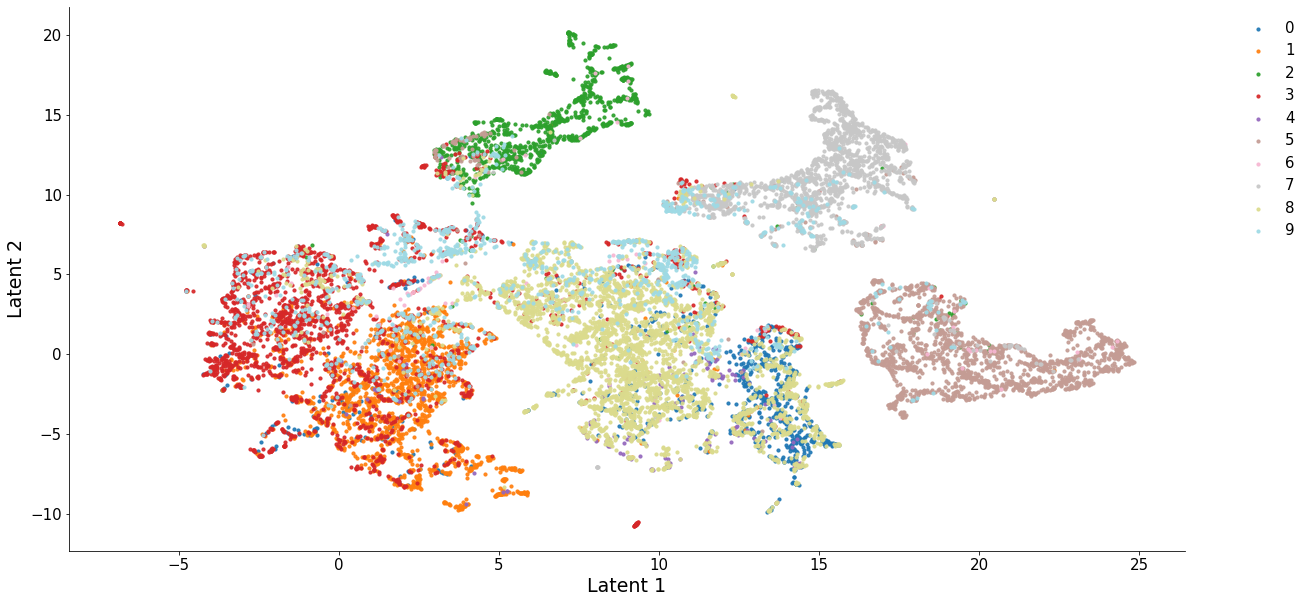

In [30]:
utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent")


## Analyzing the DE genes of cluster 7

In [12]:
# 1. obtain the feature name
genes = pd.read_csv(dir + "gene.csv", header = None).values.squeeze()
assert genes.shape[0] == model1.C_feats[0].shape[0]

feats_name = [genes]

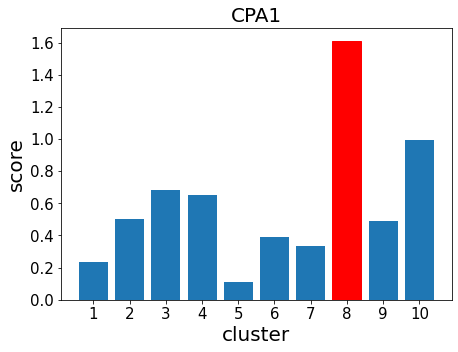

In [97]:
x_cpa1 = C_gene.iloc[np.where(genes == "CPA1")[0][0],:]

fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot()
barlist = ax.bar(np.arange(10), x_cpa1)
barlist[7].set_color('r')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_title("CPA1", fontsize = 20)
_ = ax.set_xticks(np.arange(10))
_ = ax.set_xticklabels(np.arange(10) + 1)
_ = ax.set_xlabel("cluster", fontsize = 20)
_ = ax.set_ylabel("score", fontsize = 20)


In [102]:
import importlib 
importlib.reload(utils)

<module 'utils' from '../src/utils.py'>

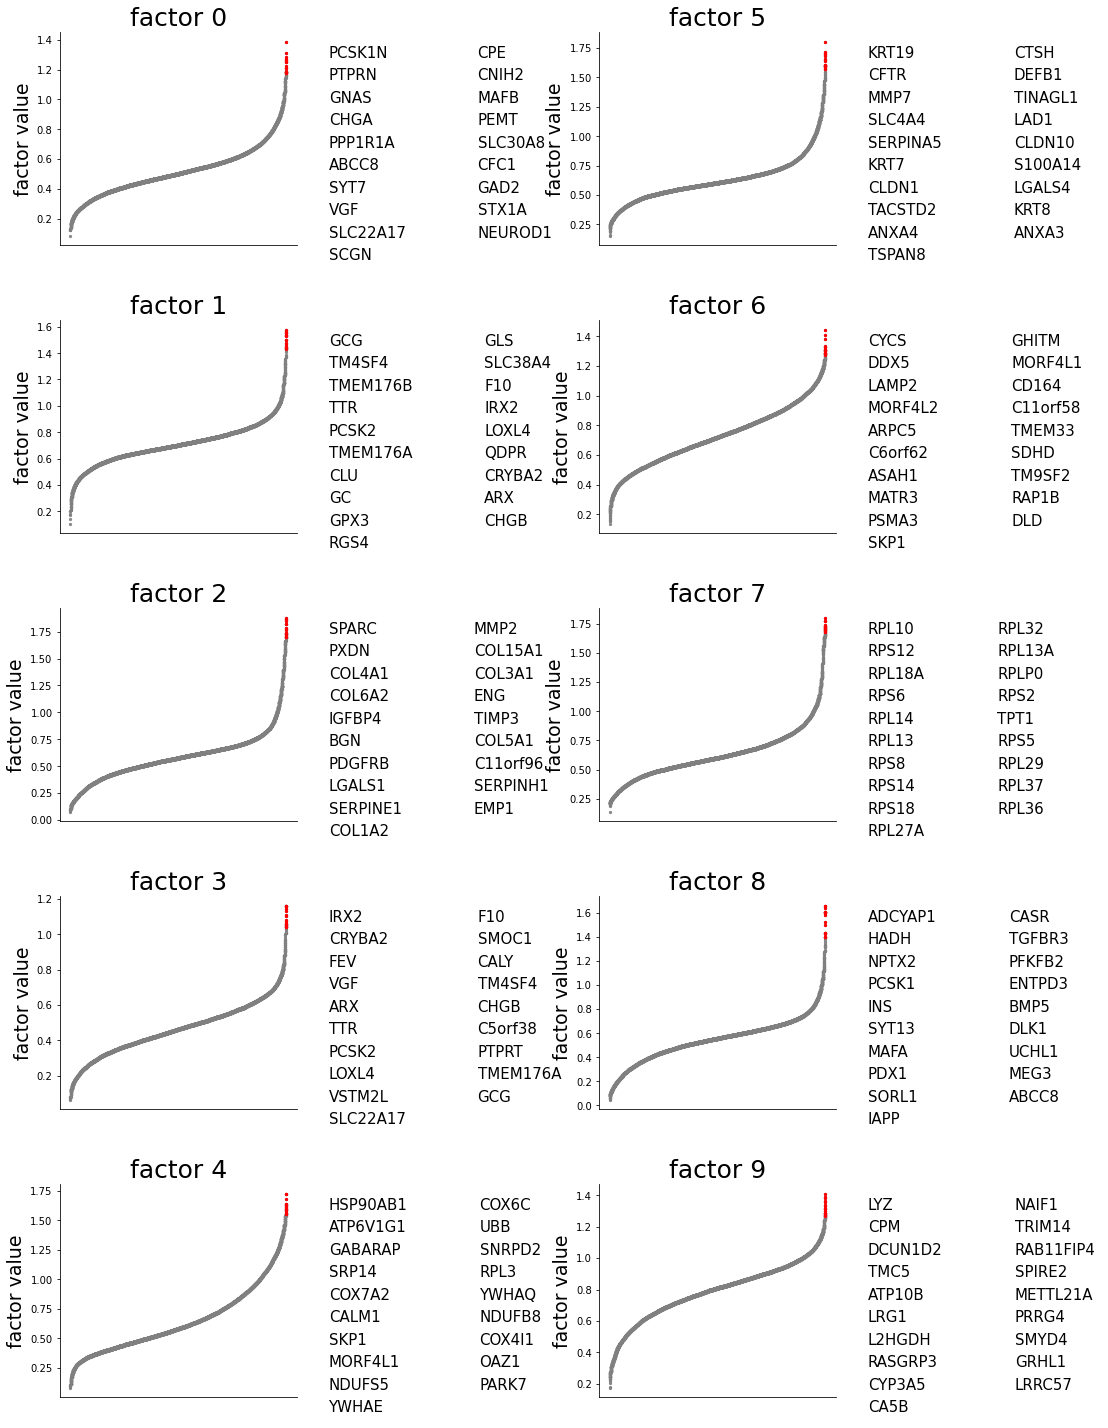

In [106]:
# Factor loading with association matrix, more like the de features
C_gene = model1.softmax(model1.C_feats[0]).data.cpu().numpy() @ model1.A_assos[0].data.cpu().numpy().T
C_gene = pd.DataFrame(data = C_gene, index = genes, columns = ["factor_" + str(i) for i in range(C_gene.shape[1])])
utils.plot_feat_score(C_gene, n_feats = 20, figsize= (15,20), save_as = None, title = None)


In [21]:
def plot_gene(zs, feat = None, save = None, figsize = (20,10), axis_label = "Latent", **kwargs):
    _kwargs = {
        "s": 10,
        "alpha": 0.9,
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)
    axs = fig.subplots(len(zs),1)

    for batch in range(len(zs)):
        axs[batch].scatter(zs[batch][:,0], zs[batch][:,1], c =  feat[batch], **_kwargs)        
        axs[batch].set_title("batch " + str(batch + 1), fontsize = 25)
        axs[batch].tick_params(axis = "both", which = "major", labelsize = 15)

        axs[batch].set_xlabel(axis_label + " 1", fontsize = 19)
        axs[batch].set_ylabel(axis_label + " 2", fontsize = 19)
        axs[batch].spines['right'].set_visible(False)
        axs[batch].spines['top'].set_visible(False)  
        
        
    if save:
        fig.savefig(save, bbox_inches = "tight")


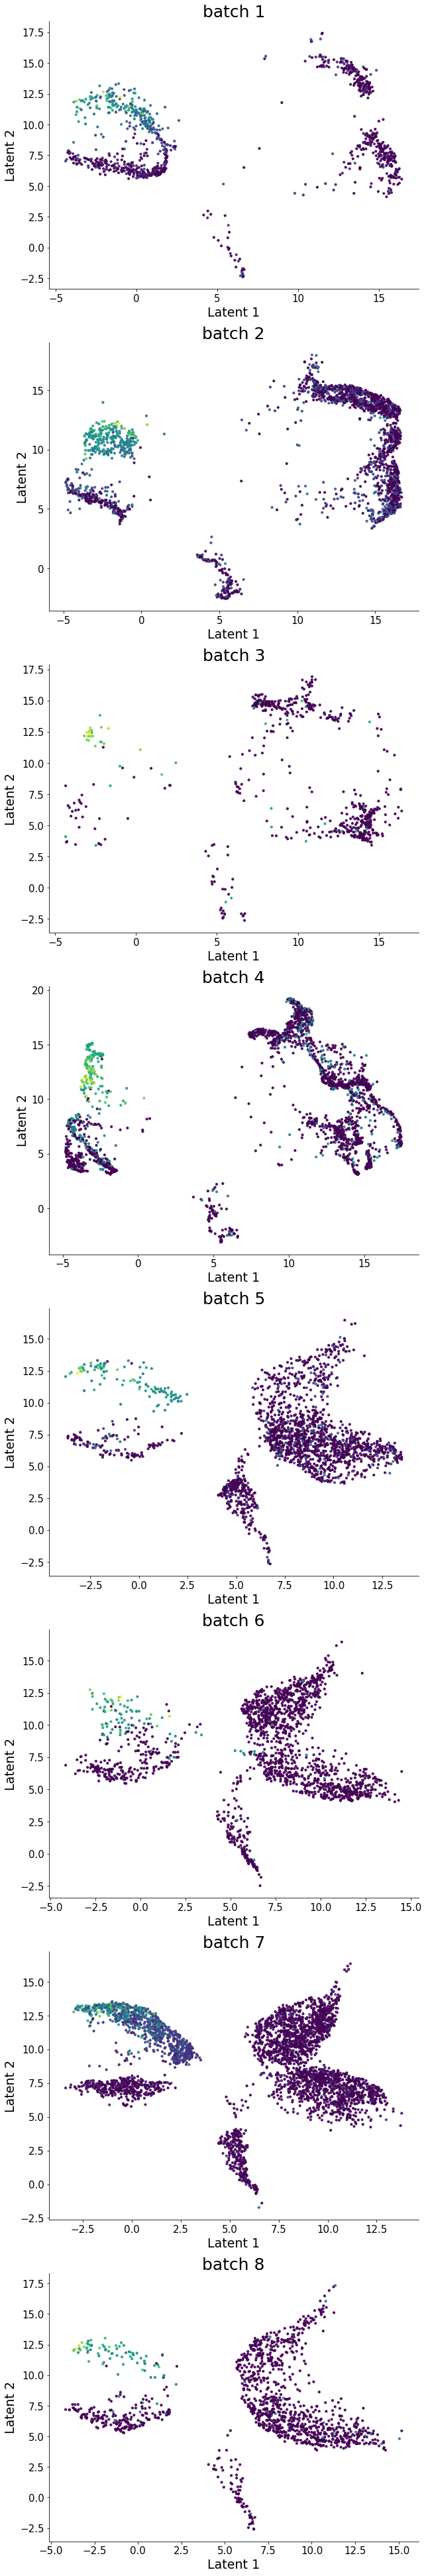

In [29]:
feats = [x[:, np.where(genes == "CPA1")].squeeze() for x in counts["rna"]]
plot_gene(x_umaps, feat = feats, save = None, figsize = (10,70), axis_label = "Latent")


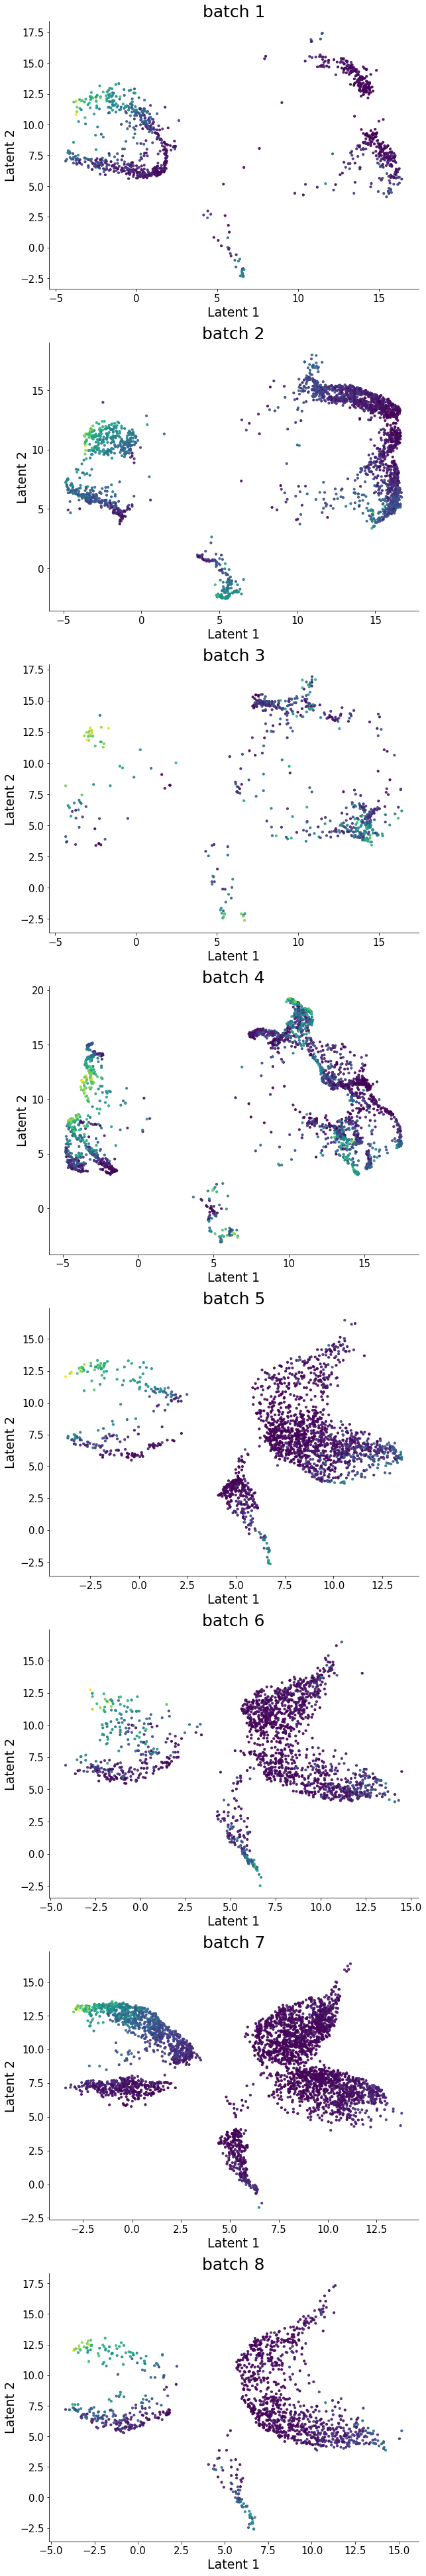

In [30]:
feats = [x[:, np.where(genes == "RPL10")].squeeze() for x in counts["rna"]]
plot_gene(x_umaps, feat = feats, save = None, figsize = (10,70), axis_label = "Latent")
